<a href="https://colab.research.google.com/github/anastasiiaCher/pyad-2024/blob/main/lab2/PY%D0%90%D0%94_%D0%9B%D0%A02_Make_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Данные

В этой лабораторной работе будем работать с [датасетом](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset), предназначенным для обучения алгоритма рекомендаций книг.

Для рекомендаций нам понадобятся таблицы `Books.csv` и `Ratings.scv`. Файл с рейтингами можно найти в папке с лабораторной работой на гитхабе. Файл с описаниями книг слишком большой, поэтому он располагается только по ссылке:
1. Файл с рейтингами (такой же, как в гитхабе): https://drive.google.com/file/d/1Hliaee7Y584-7lMoGeGjGabRRubzdoYn/view?usp=sharing
2. Файл с кригами:  https://drive.google.com/file/d/1JYpk5GTzK7GWT3mtDb9fNiwaVTzk8BBy/view?usp=sharing

In [1]:
import pandas as pd

In [2]:
!gdown 1Hliaee7Y584-7lMoGeGjGabRRubzdoYn
!gdown 1JYpk5GTzK7GWT3mtDb9fNiwaVTzk8BBy

Downloading...
From: https://drive.google.com/uc?id=1Hliaee7Y584-7lMoGeGjGabRRubzdoYn
To: /home/alvlasoff/itmo/pyad-2024/lab2/Ratings.csv
100%|██████████████████████████████████████| 22.6M/22.6M [00:02<00:00, 10.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JYpk5GTzK7GWT3mtDb9fNiwaVTzk8BBy
To: /home/alvlasoff/itmo/pyad-2024/lab2/Books.csv
100%|██████████████████████████████████████| 73.3M/73.3M [00:06<00:00, 10.9MB/s]


Посмотрим на таблицу `Ratings`.

In [3]:
ratings = pd.read_csv("Ratings.csv")
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [5]:
ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
User-ID,1149780.0,140386.395126,80562.277719,2.0,70345.0,141010.0,211028.0,278854.0
Book-Rating,1149780.0,2.866950,3.854184,0.0,0.0,0.0,7.0,10.0


Как распределяются рейтинги?

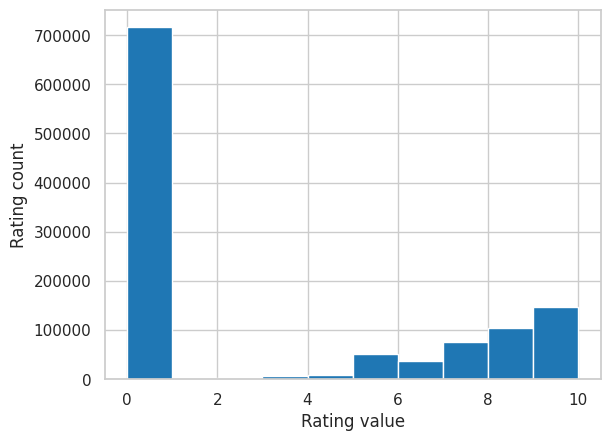

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")

ratings["Book-Rating"].hist()
plt.xlabel("Rating value")
plt.ylabel("Rating count")
plt.show()


Теперь посмотрим на таблицу `Books`.

In [7]:
books = pd.read_csv("Books.csv")
books.head()

/tmp/ipykernel_39571/156505208.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("Books.csv")


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [8]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


- Есть немножко пропусков.
- Проверим уязвимую часть данных – года – на адекватность.

In [9]:
books["Year-Of-Publication"].value_counts().sort_values(ascending=True)[:10]

Year-Of-Publication
2037    1
2011    1
2038    1
1938    1
1906    1
1919    1
1926    1
1926    1
2008    1
2024    1
Name: count, dtype: int64

Есть года, которые еще не наступили...

Проверим, есть ли строковые данные в столбце с годом (потому что `info()` назвал тип данных столбца `object`).

In [10]:
books[books["Year-Of-Publication"].map(str).str.match("[^0-9]")]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


В трех строках пропущен автор, из-за чего смещены данные. Автор либо пропущен, либо склеен с названием. Надо проверить.

В сводке написано, что часть авторов и издателей провущена. Проверим, так ли это.

In [11]:
books[(books["Book-Author"].isnull()) | (books["Publisher"].isnull())]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


Да, это так. Основные проблемы с данными выявили. Пора их исправлять и приступать к созданию рекомендаций.

## План анализа данных

1. Обработать данные, т.к. в данных есть несколько небольших проблем:
  1. В паре строк в таблице `Books.scv` значения столбцов сдвинуты вправо, а еще есть года, которые еще не наступили.
  2. В нескольких строках в таблице `Books.scv` есть пропуски, а также для рекомендаций в рамках лабораторной не понадобятся ссылки на картинки с обложкой.
  3. Не будем использовать для обучения записи с рейтинг равным 0 из таблицы `Ratings.scv`. Считаем, что 0 означает, что пользователь еще не оценивал книгу, но проявил к ней какой-то интерес.
  4. Не будем использовать для обучения алгоритмов те книги, которым оценка поставлена всего 1 раз. Пользователей, оценивших всего одну книгу тоже брать в расчет не будем (хотя это на самом деле будет не сильно сказываться на обобщающей способности алгоритмов, можете сами проверить).
  5. Пункты 1-4 необходимы и достаточны для выполнения всех задач. Но можно сделать более глубокую обработку.
2. Обучить [SVD](https://surprise.readthedocs.io/en/stable/getting_started.html) на следующих записях: у книги есть хотя бы одна оценка, пользователь оценил хотя бы одну книгу.
   - МАЕ должно быть ниже 1.3 (для этого есть тест)
   - **Сохранить модель.**
3. Научить линейную регрессию ([SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)) предсказывать средний рейтинг книги по следующим столбцам: автор, издатель, год издания, векторизованное название (для векторизации можно использовать [tf-idf](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting), [word2vec](https://radimrehurek.com/gensim/models/word2vec.html) или более сложный алгоритм. Для достижения требуемой тестом точности достаточно будет tf-idf. Собрав полностью датасет, не забудьте нормализовать данные ([StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)).
   - МАЕ должно быть ниже 1.5 (для этого есть тест)
   - **Сохранить модель.**
4. В файле `personal_recommendation.py` создайте рекомендацию для пользователя, у которого в исходном датасете было больше всего 0 среди рейтингов книг.
   Алгоритм такой:
   1. Находим нужного пользователя.
   2. Делаем предсказание SVD для книг, которым он "поставил" 0.
   3. Берем те книги, для которых предсказали рейтинг не ниже 8. Считаем, что 8 означет, что книга ему точно понравится.
   4. Делаем предсказание LinReg для этих же книг.
   5. Сортируем полученный на шаге 3 список по убыванию рейтинга линейной модели.
   6. В конце файла комментарием записываем полученную рекомендацию.

- То есть идея в том, чтобы сделать для пользователя индивидуальную рекомендацию, показывая в начале списка те книги, которые в целом могли бы иметь высокий рейтинг.
- Обязательно сохраняйте готовую модель и добавляйте ее в свой репозиторий, потому что файл с сохраненной моделью используется в тестах.

## Куда сдавать?

По инструкции в гитхаб – https://shy-question-39d.notion.site/1150ea832e418032bfc3d3e827c380fb?pvs=74

- К этой работе есть два теста – на качество получившихся моделей.
- Пул-реквест нужно сделать в ветку `lab2`.
- Можно загрузить в гитхаб файлы с реализацией по шаблону (шаблон можно дополнять и изменять под себя) или подготовить колаб с решением. Главное – сохранить модели, тесты проверяют их.

> Будьте внимательны! На гитхабе в ветке `main` обновился файл `pyad.yml`.

**Устная защита работ не требуется, но вам могут быть заданы вопросы прямо в вашем пул-реквесте!**

In [12]:
!pip install scikit-surprise


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [13]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

## Обработка 

Сдвиги:

In [14]:
books["Year-Of-Publication"] = books["Year-Of-Publication"].astype(str)
column_names = books.columns.tolist()
start = column_names.index("Book-Author")

shifted = books[books["Year-Of-Publication"].str.match("[^0-9]", na=False)]

for i in shifted.index:
    row_data = books.loc[i]
    for j in range(len(column_names) - 1, start, -1):
        row_data[column_names[j]] = row_data[column_names[j - 1]]
    row_data[column_names[start]] = np.nan
    books.loc[i] = row_data

/tmp/ipykernel_39571/2247957300.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_data[column_names[j]] = row_data[column_names[j - 1]]
/tmp/ipykernel_39571/2247957300.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_data[column_names[start]] = np.nan
/tmp/ipykernel_39571/2247957300.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_data[column_names[j]] = row_data[column_names[j - 1]]
/tmp/ipykernel_39571/22479573

Ненаступившие года, столбцы с картинками, нулевой рейтинг

In [15]:
books = books[books["Year-Of-Publication"].astype(int) < 2025]
books = books.iloc[:, :-3]
ratings = ratings[ratings["Book-Rating"] != 0]
books = books[books["ISBN"].isin(ratings["ISBN"])]
ratings = ratings.groupby("User-ID").filter(lambda x: len(x) > 1)

## Обучение SVD

In [16]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(ratings[["User-ID","ISBN","Book-Rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd = SVD()
svd.fit(trainset)

In [17]:
import pickle
predictions = svd.test(testset)
mae = accuracy.mae(predictions)

with open("svd.pkl", "wb") as model_file:
    pickle.dump(svd, model_file)

MAE:  1.2516


Получили MAE < 1.3

## Обучение линейной регрессии

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

average_ratings = ratings.groupby("ISBN")["Book-Rating"].mean().reset_index()
average_ratings.rename(columns={"Book-Rating": "Average-Rating"}, inplace=True)

data_linreg = pd.merge(books, average_ratings, on="ISBN", how="left").dropna(subset=["Average-Rating"])

X = data_linreg[["Book-Title","Book-Author","Publisher","Year-Of-Publication"]]
y = data_linreg["Average-Rating"]

title_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ("title", title_vectorizer, "Book-Title"),
    ("author", categorical_encoder, ["Book-Author"]),
    ("publisher", categorical_encoder, ["Publisher"]),
    ("year", numeric_transformer, ["Year-Of-Publication"])
])

model_linreg = Pipeline([
    ("preprocessing", preprocessor),
    ("regressor", SGDRegressor(random_state=42, max_iter=1000, tol=1e-3))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)
model_linreg.fit(X_train, y_train)

y_pred = model_linreg.predict(X_test)
linreg_mae = mean_absolute_error(y_test, y_pred)

print(linreg_mae)

1.3184464225233017


Получили MAE < 1.5

In [19]:
with open("linreg.pkl", "wb") as file:
  pickle.dump(model_linreg, file)